In [3]:
import os
# Data Manipulation
import pandas as pd
import numpy as np
from math import sqrt

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Utilities
from ast import literal_eval
import datetime
import pickle
from datetime import datetime
from contextlib import redirect_stdout

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Surprise Library
from surprise import (Reader, Dataset, SVD, SVDpp, KNNBasic, NMF, CoClustering, SlopeOne,NormalPredictor, KNNBaseline, KNNWithMeans, KNNWithZScore, BaselineOnly,accuracy, accuracy)
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV

In [4]:
movies_df=pd.read_csv(r"")
credits_df=pd.read_csv(r"")
keywords_df=pd.read_csv(r"")
ratings_df=pd.read_csv(r"")

C:\Users\visha\AppData\Local\Temp\ipykernel_3448\1311909981.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies_df=pd.read_csv(r"C:\Vishakh\Major Project\MEDIUM DATASET\movies_metadata.csv")


In [5]:
movies_df = movies_df[~(movies_df['id'].str.contains('-'))]
movies_df['id'] = movies_df['id'].astype('int64')
movies_df = pd.merge(movies_df, keywords_df, on='id', how='left')
movies_df = pd.merge(movies_df, credits_df, on='id', how='left')

In [6]:
column_to_drop = ['belongs_to_collection', 'homepage', 'status', 'video']
movies_df = movies_df.drop(column_to_drop, axis=1)

text_columns = ['original_language','tagline']
movies_df[text_columns] = movies_df[text_columns].fillna('')

number_columns = ['runtime']
movies_df[number_columns] = movies_df[number_columns].fillna(0)

movies_df.dropna(inplace=True)
movies_df.head()

,adult,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,poster_path,...,revenue,runtime,spoken_languages,tagline,title,vote_average,vote_count,keywords,cast,crew
0,False,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,...,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",,Toy Story,7.7,5415.0,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,False,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,...,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Roll the dice and unleash the excitement!,Jumanji,6.9,2413.0,"[{'id': 10090, 'name': 'board game'}, {'id': 1...","[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
2,False,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,...,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,6.5,92.0,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392...","[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de..."
3,False,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,...,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Friends are the people who let you be yourself...,Waiting to Exhale,6.1,34.0,"[{'id': 818, 'name': 'based on novel'}, {'id':...","[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de..."
4,False,0,"[{'id': 35, 'name': 'Comedy'}]",11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,...,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,5.7,173.0,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...","[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de..."


In [7]:
movies_df['year'] = pd.to_datetime(movies_df['release_date'], errors='coerce').dt.year

movies_df['year'] = movies_df['year'].astype(int)

movies_df['release_date'] = pd.to_datetime(movies_df['release_date'], format="%Y-%m-%d", errors='coerce')

movies_df['popularity'] = movies_df['popularity'].astype('float64')

ratings_df['timestamp'] = ratings_df['timestamp'].apply(lambda x: datetime.fromtimestamp(x))

In [8]:
def extend_list_from_column(df, column_name, target_list, key='name'):
    temp_df = df[column_name].fillna('[]').apply(literal_eval).apply(lambda x: [i[key] for i in x] if isinstance(x, list) else [])
    for i in temp_df:
        if i:
            target_list.extend(i)

def get_director(x):
    return next((i['name'] for i in x if i['job'] == 'Director'), np.nan)

def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        return names[:3] if len(names) > 3 else names
    return []

def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

def create_bag_of_words(x):
    return ' '.join(x['keywords'] + x['cast'] + [x['director']] + x['genres'])

spoken_languages_list = []
cast_list = []
crew_list = []
company_list = []
country_list = []
original_language_list = []

for i in movies_df['original_language']:
    original_language_list.extend(i.split(', '))

extend_list_from_column(movies_df, 'spoken_languages', spoken_languages_list)
extend_list_from_column(movies_df, 'cast', cast_list, key='character')
extend_list_from_column(movies_df, 'crew', crew_list)
extend_list_from_column(movies_df, 'production_companies', company_list)
extend_list_from_column(movies_df, 'production_countries', country_list)

for col in ['crew', 'cast', 'genres', 'keywords', 'production_companies']:
    movies_df[col] = movies_df[col].fillna('[]').apply(literal_eval)

movies_df['director'] = movies_df['crew'].apply(get_director)

for col in ['cast', 'genres', 'keywords', 'production_companies']:
    movies_df[col] = movies_df[col].apply(get_list)

features = ['adult', 'cast', 'keywords', 'director', 'genres', 'production_companies']
for feature in features:
    movies_df[feature] = movies_df[feature].apply(clean_data)

movies_df['bag_of_words'] = movies_df.apply(create_bag_of_words, axis=1)

In [9]:
train_df, test_df = train_test_split(ratings_df.head(50000), test_size=0.2, random_state=42)

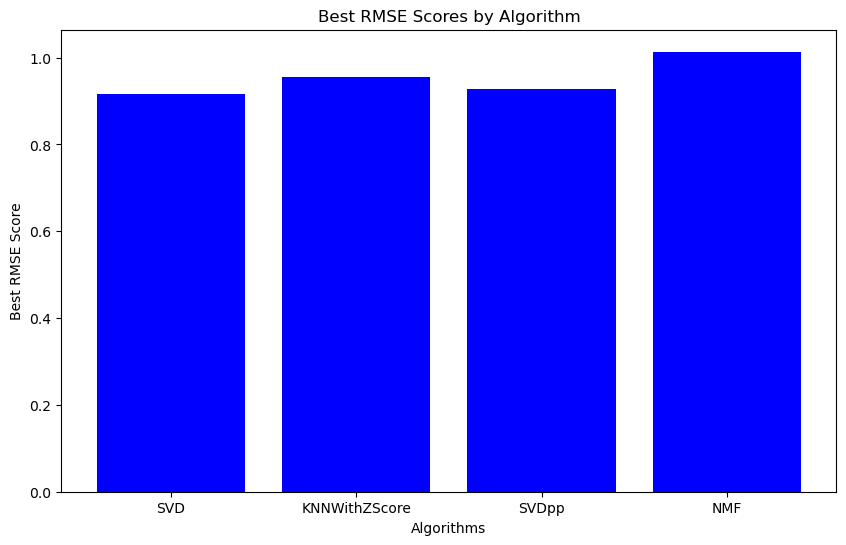

Best Model for SVD:
Best Parameters for SVD:
 {'n_factors': 125, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.15}
Best RMSE score for SVD:
 0.9171122135103572
Best Model for KNNWithZScore:
Best Parameters for KNNWithZScore:
 {'k': 40, 'min_k': 3, 'sim_options': {'name': 'cosine', 'user_based': True}}
Best RMSE score for KNNWithZScore:
 0.9564173327695551
Best Model for SVDpp:
Best Parameters for SVDpp:
 {'n_factors': 20, 'n_epochs': 25, 'lr_all': 0.002, 'reg_all': 0.18}
Best RMSE score for SVDpp:
 0.928521330085494
Best Model for NMF:
Best Parameters for NMF:
 {'n_factors': 20, 'n_epochs': 50, 'biased': False}
Best RMSE score for NMF:
 1.0136826029056663


In [10]:
from contextlib import redirect_stdout

reader = Reader(rating_scale=(1, 5))

train_data = Dataset.load_from_df(train_df[['userId', 'movieId', 'rating']], reader)
test_data = Dataset.load_from_df(test_df[['userId', 'movieId', 'rating']], reader)

trainset = train_data.build_full_trainset()
testset = test_data.build_full_trainset().build_testset()

algorithms = [SVD, KNNWithZScore, SVDpp, NMF]

param_grid = {
    SVD: {
        'n_factors': [125, 150],
        'n_epochs': [25, 30],
        'lr_all': [0.008, 0.01],
        'reg_all': [0.15, 0.2]
    },
    KNNWithZScore: {
        'k': [35, 40],
        'min_k': [1, 3],
        'sim_options': {
            'name': ['msd', 'cosine'],
            'user_based': [True, False]
        }
    },
    SVDpp: {
        'n_factors': [20, 50],
        'n_epochs': [20, 25],
        'lr_all': [0.001, 0.002],
        'reg_all': [0.18, 0.2]
    },
    NMF: {
        'n_factors': [15, 20],
        'n_epochs': [50, 60],
        'biased': [True, False]
    }
}

best_models = {}
best_params = {}
best_rmse_scores = {}

for algo in algorithms:
    gs = GridSearchCV(algo, param_grid[algo], measures=['rmse'], cv=3)
    with redirect_stdout(None):
      gs.fit(train_data)

    best_models[algo.__name__] = gs.best_estimator['rmse']
    best_params[algo.__name__] = gs.best_params['rmse']
    best_rmse_scores[algo.__name__] = gs.best_score['rmse']

plt.figure(figsize=(10, 6))
plt.bar(best_rmse_scores.keys(), best_rmse_scores.values(), color='blue')
plt.xlabel('Algorithms')
plt.ylabel('Best RMSE Score')
plt.title('Best RMSE Scores by Algorithm')
plt.show()

for algo_name, model in best_models.items():
    print(f"Best Model for {algo_name}:\n", model)
    print(f"Best Parameters for {algo_name}:\n", best_params[algo_name])
    print(f"Best RMSE score for {algo_name}:\n", best_rmse_scores[algo_name])

In [11]:
best_algo_name = min(best_rmse_scores, key=best_rmse_scores.get)
best_algo_model = best_models[best_algo_name]

with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_algo_model, f)

print("Best model saved to 'best_model.pkl'")

best_algo_model.fit(trainset)

predictions = best_algo_model.test(testset)

rmse_score = accuracy.rmse(predictions)

mae_score = accuracy.mae(predictions)
fcp_score = accuracy.fcp(predictions)

print(f"Evaluation Metrics:")
print(f"RMSE score: {rmse_score}")
print(f"MAE score: {mae_score}")
print(f"FCP score: {fcp_score}")

predictions_df = pd.DataFrame(predictions)
predictions_df = predictions_df.rename(columns={'uid': 'userId', 'iid': 'movieId', 'r_ui': 'actual', 'est': 'predicted'})
predictions_df['error'] = np.abs(predictions_df['actual'] - predictions_df['predicted'])

predictions_df.to_csv('predictions.csv', index=False)

Best model saved to 'best_model.pkl'
RMSE: 0.8994
MAE:  0.6977
FCP:  0.6304
Evaluation Metrics:
RMSE score: 0.8993665702553028
MAE score: 0.6977190070092993
FCP score: 0.630360890192439


In [12]:
movies_df = movies_df[(movies_df['vote_average'].notnull()) | (movies_df['vote_count'].notnull())]

R = movies_df['vote_average']

v = movies_df['vote_count']

m = movies_df['vote_count'].quantile(0.9)

C = movies_df['vote_average'].mean()

movies_df['weighted_average'] = (R * v + C * m) / (v + m)

current_year = 2020 #lastest year movie release on the data
movies_df['time_decay_factor'] = 1 / (current_year - movies_df['year'] + 1)

max_revenue = movies_df['revenue'].max()
min_revenue = movies_df['revenue'].min()
movies_df['normalized_revenue'] = (movies_df['revenue'] - min_revenue) / (max_revenue - min_revenue)

scaler = MinMaxScaler()

scaled = scaler.fit_transform(
    movies_df[['popularity', 'weighted_average', 'time_decay_factor', 'normalized_revenue']]
)

weighted_df = pd.DataFrame(
    scaled,
    columns=['popularity', 'weighted_average', 'time_decay_factor', 'normalized_revenue']
)

weighted_df.index = movies_df['id']

weighted_df['score'] = (
    weighted_df['weighted_average'] * 0.4 +
    weighted_df['popularity'] * 0.4 +
    weighted_df['time_decay_factor'] * 0.05 +
    weighted_df['normalized_revenue'] * 0.15
)

weighted_df_sorted = weighted_df.sort_values(by='score', ascending=False)

top_10_movies = weighted_df_sorted.head(10)

result_df = pd.merge(top_10_movies, movies_df[['id','original_title', 'year', 'revenue']], on='id', how='left')

result_df[['original_title', 'year', 'revenue', 'score', 'id']]

,original_title,year,revenue,score,id
0,Minions,2015,1.156731e+09,0.699055,211672
1,Avatar,2009,2.787965e+09,0.584354,19995
2,Wonder Woman,2017,8.205804e+08,0.564407,297762
3,Beauty and the Beast,2017,1.262886e+09,0.551252,321612
4,Big Hero 6,2014,6.521054e+08,0.540299,177572
5,The Dark Knight,2008,1.004558e+09,0.532660,155
6,Guardians of the Galaxy Vol. 2,2017,8.634161e+08,0.518944,283995
7,Deadpool,2016,7.831130e+08,0.500611,293660
8,Pulp Fiction,1994,2.139288e+08,0.499935,680
9,Gone Girl,2014,3.693304e+08,0.489802,210577


In [13]:
result_df.to_pickle('result_df.pkl')
print("result_df has been saved to 'result_df.pkl'")


result_df has been saved to 'result_df.pkl'


In [14]:
from contextlib import redirect_stdout
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score

all_evaluation_metrics = {}

for algo in algorithms:
    best_algo_model = best_models[algo.__name__]

    with redirect_stdout(None):
        best_algo_model.fit(trainset)

    predictions = best_algo_model.test(testset)

    actual_ratings = [prediction.r_ui for prediction in predictions]
    predicted_ratings = [prediction.est for prediction in predictions]

    binary_actual = [1 if rating >= 3.5 else 0 for rating in actual_ratings]
    binary_predicted = [1 if rating >= 3.5 else 0 for rating in predicted_ratings]

    rmse_score = accuracy.rmse(predictions)
    mae_score = accuracy.mae(predictions)
    fcp_score = accuracy.fcp(predictions)

    acc_score = accuracy_score(binary_actual, binary_predicted)
    
    precision = precision_score(binary_actual, binary_predicted)
    recall = recall_score(binary_actual, binary_predicted)
    f1 = f1_score(binary_actual, binary_predicted)

    all_evaluation_metrics[algo.__name__] = {
        'RMSE': rmse_score,
        'MAE': mae_score,
        'FCP': fcp_score,
        'Accuracy': acc_score,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

print("All Evaluation Metrics:\n")
for algo_name, metrics in all_evaluation_metrics.items():
    print(f"{algo_name}:")
    print(f"RMSE: {metrics['RMSE']}")
    print(f"MAE: {metrics['MAE']}")
    print(f"FCP: {metrics['FCP']}")
    print(f"Accuracy: {metrics['Accuracy']}")
    print(f"Precision: {metrics['Precision']}")
    print(f"Recall: {metrics['Recall']}")
    print(f"F1 Score: {metrics['F1 Score']}")
    print("")


RMSE: 0.8982
MAE:  0.6968
FCP:  0.6312
RMSE: 0.9296
MAE:  0.7141
FCP:  0.5988
RMSE: 0.9106
MAE:  0.7085
FCP:  0.6255
RMSE: 0.9829
MAE:  0.7540
FCP:  0.6157
All Evaluation Metrics:

SVD:
RMSE: 0.898176555578422
MAE: 0.6967808546974044
FCP: 0.6311909535549913
Accuracy: 0.6949
Precision: 0.7890570021111893
Recall: 0.7077481458103203
F1 Score: 0.7461941602196156

KNNWithZScore:
RMSE: 0.9296490784150832
MAE: 0.7141301063975195
FCP: 0.598761050967585
Accuracy: 0.6883
Precision: 0.7668213457076566
Recall: 0.7301562253432223
F1 Score: 0.7480397704308464

SVDpp:
RMSE: 0.910634086064106
MAE: 0.708518354820122
FCP: 0.6255140905966672
Accuracy: 0.6881
Precision: 0.7832746478873239
Recall: 0.7020672242385987
F1 Score: 0.7404510277107431

NMF:
RMSE: 0.9828556602469761
MAE: 0.7539583489254044
FCP: 0.6157198333808046
Accuracy: 0.6715
Precision: 0.7556113902847571
Recall: 0.7118510336121193
F1 Score: 0.7330787356788818



In [15]:
print("All Evaluation Metrics:\n")
for algo_name, metrics in all_evaluation_metrics.items():
    print(f"{algo_name}:")
    print(f"RMSE: {metrics['RMSE']}")
    print(f"MAE: {metrics['MAE']}")
    print(f"FCP: {metrics['FCP']}")
    print(f"Accuracy: {metrics['Accuracy']}")
    print(f"Precision: {metrics['Precision']}")
    print(f"Recall: {metrics['Recall']}")
    print(f"F1 Score: {metrics['F1 Score']}")
    print("")


All Evaluation Metrics:

SVD:
RMSE: 0.898176555578422
MAE: 0.6967808546974044
FCP: 0.6311909535549913
Accuracy: 0.6949
Precision: 0.7890570021111893
Recall: 0.7077481458103203
F1 Score: 0.7461941602196156

KNNWithZScore:
RMSE: 0.9296490784150832
MAE: 0.7141301063975195
FCP: 0.598761050967585
Accuracy: 0.6883
Precision: 0.7668213457076566
Recall: 0.7301562253432223
F1 Score: 0.7480397704308464

SVDpp:
RMSE: 0.910634086064106
MAE: 0.708518354820122
FCP: 0.6255140905966672
Accuracy: 0.6881
Precision: 0.7832746478873239
Recall: 0.7020672242385987
F1 Score: 0.7404510277107431

NMF:
RMSE: 0.9828556602469761
MAE: 0.7539583489254044
FCP: 0.6157198333808046
Accuracy: 0.6715
Precision: 0.7556113902847571
Recall: 0.7118510336121193
F1 Score: 0.7330787356788818



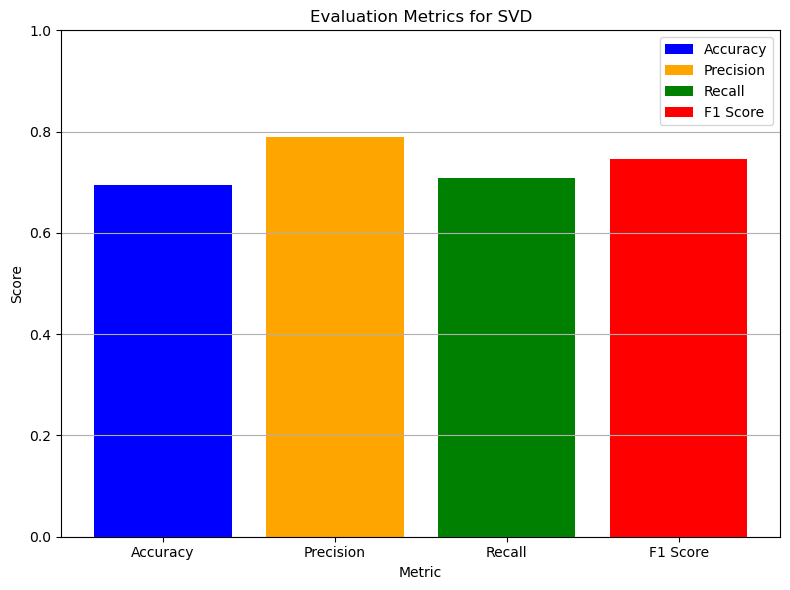

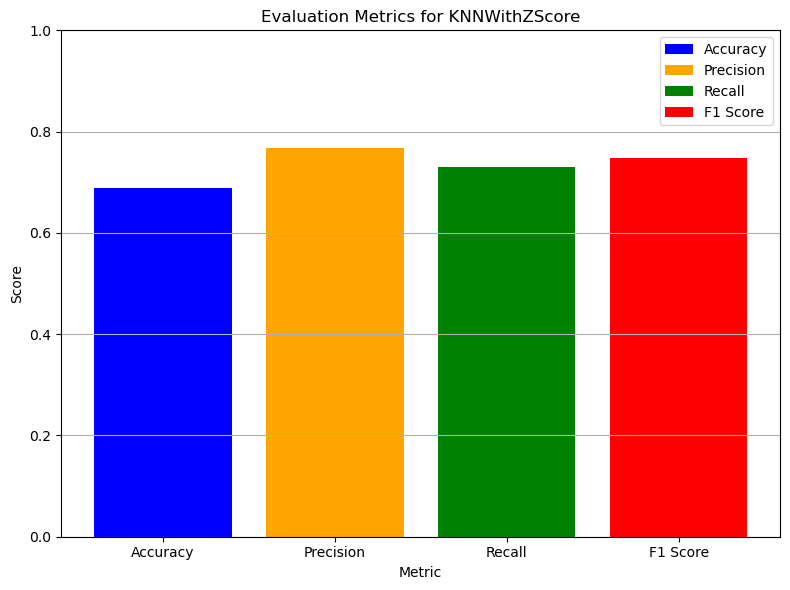

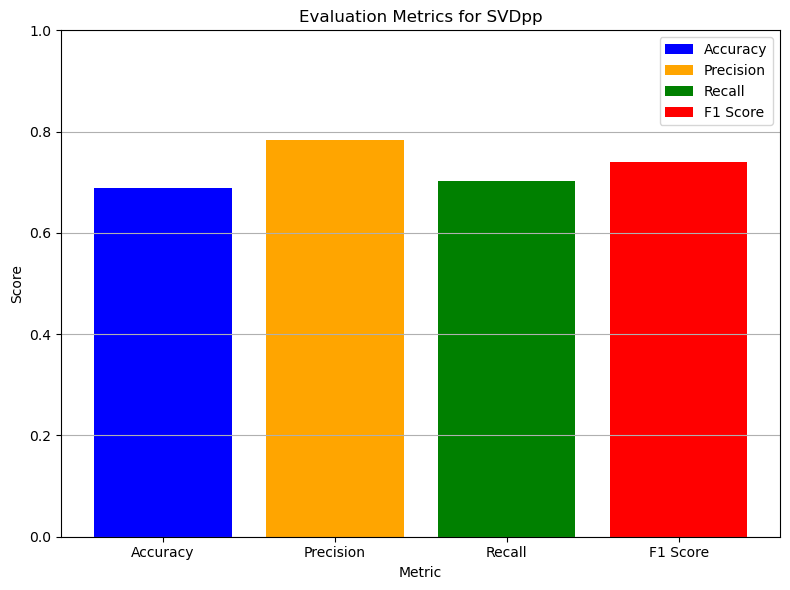

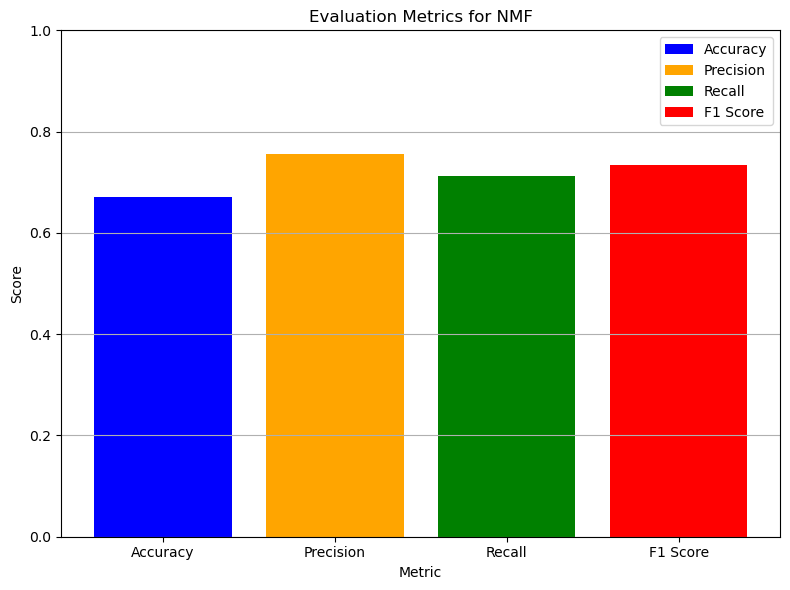

In [30]:
import matplotlib.pyplot as plt

for algo_name, metrics in all_evaluation_metrics.items():
    plt.figure(figsize=(8, 6))

    plt.bar('Accuracy', metrics['Accuracy'], color='blue', label='Accuracy')
    plt.bar('Precision', metrics['Precision'], color='orange', label='Precision')
    plt.bar('Recall', metrics['Recall'], color='green', label='Recall')
    plt.bar('F1 Score', metrics['F1 Score'], color='red', label='F1 Score')

    plt.title(f'Evaluation Metrics for {algo_name}')
    plt.xlabel('Metric')
    plt.ylabel('Score')
    plt.legend()
    plt.ylim(0, 1)  # Set y-axis limit from 0 to 1 for consistency
    plt.grid(axis='y')
    plt.tight_layout()

    plt.savefig(f'{algo_name}_metrics.png')

    # Show the bar chart
    plt.show()
